In [2]:
# import package
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
import lightgbm as lgb

import math
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.sparse import csr_matrix, hstack


# define constant
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

# define function
def RMSE(ground_truth, predictions):
    # define RMSE
    return math.sqrt(mean_squared_error(ground_truth, predictions))

def split_cat(text):
    # split category_name
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")
    
def handle_missing_inplace(dataset):
    # handle missing values of brand_name and item_description
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)


def cutting(dataset):
    # 对brand_name中出现频率没有在前NUM_BRANDS的用‘missing'替代
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    # 同理，对category_name进行相同操作
    pop_category1 = dataset['general_cat'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    pop_category2 = dataset['subcat_1'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    pop_category3 = dataset['subcat_2'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]
    dataset.loc[~dataset['general_cat'].isin(pop_category1), 'general_cat'] = 'missing'
    dataset.loc[~dataset['subcat_1'].isin(pop_category2), 'subcat_1'] = 'missing'
    dataset.loc[~dataset['subcat_2'].isin(pop_category3), 'subcat_2'] = 'missing'

In [3]:
import time
start_time = time.time()

# step1:load data
print("step1:load data")
    
# load data
train = pd.read_table('./data/train.tsv', delimiter='\t')
test = pd.read_table('./data/test.tsv', delimiter='\t')
print('load data completed')
    
# drop train where price=0
train.drop(train[(train.price == 0)].index, inplace=True)
train_len = train.shape[0]
y = np.log1p(train["price"])
print('drop train with price=0 completed')

# concat data
merge = pd.concat([train, test])
print('concat train and test completed')


# step2:feature engineering
print("step2:feature engineering")
    
# category_name
merge['general_cat'], merge['subcat_1'], merge['subcat_2'] = zip(*merge['category_name'].apply(lambda x: split_cat(x)))
merge.drop('category_name', axis=1, inplace=True)
print('split `category_name` completed')
    
# brand_name & item_description
handle_missing_inplace(merge)
print('handle missing values of `brand_name&item_description` completed')

# category_name & brand_name
cutting(merge)
print('cut `category_name&brand_name` completed')
    
# name
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])
print('CountVectorizer `name` completed')
    
# category_name
cv = CountVectorizer()
X_category1 = cv.fit_transform(merge['general_cat'])
X_category2 = cv.fit_transform(merge['subcat_1'])
X_category3 = cv.fit_transform(merge['subcat_2'])
print('CountVectorizer `category_name` completed')
    
# item_description
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION,
                        ngram_range=(1, 3),
                        stop_words='english')
X_description = tv.fit_transform(merge['item_description'])
print('TfidfVectorizer `item_description` completed')
    
# brand_name
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])
print('LabelBinarizer `brand_name` completed')
    
# item_condition_id & shipping
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']],sparse=True).values)
print('Get dummies on `item_condition_id&shipping` completed')
        
# combine to create new merge
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category1, X_category2, X_category3, X_name)).tocsr()
print('Create sparse merge completed')
print('sparse_merge shape is ',sparse_merge.shape)

X = sparse_merge[:train_len]
X_test = sparse_merge[train_len:]

print('it all cost ',time.time()-start_time,'s')

step1:load data
load data completed
drop train with price=0 completed
concat train and test completed
step2:feature engineering
split `category_name` completed
handle missing values of `brand_name&item_description` completed
cut `category_name&brand_name` completed
CountVectorizer `name` completed
CountVectorizer `category_name` completed
TfidfVectorizer `item_description` completed
LabelBinarizer `brand_name` completed
Get dummies on `item_condition_id&shipping` completed
Create sparse merge completed
sparse_merge shape is  (2175020, 76391)
it all cost  1373.3088471889496 s


In [4]:
# Ridge
start_time=time.time()
train_X3, valid_X3, train_y3, valid_y3 = train_test_split(X, y, test_size = 0.1, random_state = 20) 

model = Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=50,
normalize=False, random_state=101, solver='auto', tol=0.03)
model.fit(train_X3, train_y3)
    
trainR3 = model.predict(train_X3)
print('training rmse:', RMSE(train_y3, trainR3))
validR3 = model.predict(valid_X3)
print('valid rmse:', RMSE(valid_y3, validR3))

print('it cost', time.time()-start_time, 's')

training rmse: 0.4426921801837907
valid rmse: 0.46253413578123104
it cost 26.13662624359131 s


In [5]:
merge['ship_plus_ici'] = merge['item_condition_id']+merge[ 'shipping']
merge.head()

,brand_name,item_condition_id,item_description,name,price,shipping,test_id,train_id,general_cat,subcat_1,subcat_2,ship_plus_ici
0,missing,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,10.0,1,NaN,0.0,Men,Tops,T-shirts,4
1,Razer,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,52.0,0,NaN,1.0,Electronics,Computers & Tablets,Components & Parts,3
2,Target,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,10.0,1,NaN,2.0,Women,Tops & Blouses,Blouse,2
3,missing,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues,35.0,1,NaN,3.0,Home,Home Décor,Home Décor Accents,2
4,missing,1,Complete with certificate of authenticity,24K GOLD plated rose,44.0,0,NaN,4.0,Women,Jewelry,Necklaces,1


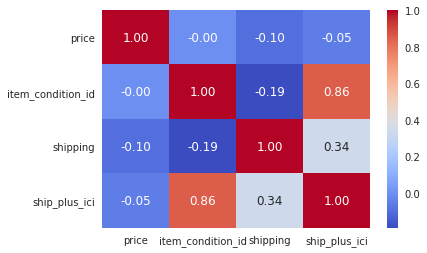

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')

g = sns.heatmap(merge[:train_len][["price","item_condition_id","shipping","ship_plus_ici"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
plt.show(g)

In [9]:
X_dummies1 = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping','ship_plus_ici']],sparse=True).values)
sparse_merge1 = hstack((X_dummies1, X_description, X_brand, X_category1, X_category2, X_category3, X_name)).tocsr()
print('Create sparse merge completed')

X1 = sparse_merge1[:train_len]
X_test1 = sparse_merge1[train_len:]

Create sparse merge completed


In [10]:
# Ridge
start_time=time.time()
train_X3, valid_X3, train_y3, valid_y3 = train_test_split(X1, y, test_size = 0.1, random_state = 20) 

model = Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=50,
normalize=False, random_state=101, solver='auto', tol=0.03)
model.fit(train_X3, train_y3)
    
trainR3 = model.predict(train_X3)
print('training rmse:', RMSE(train_y3, trainR3))
validR3 = model.predict(valid_X3)
print('valid rmse:', RMSE(valid_y3, validR3))

print('it cost', time.time()-start_time, 's')

training rmse: 0.443269894991585
valid rmse: 0.46266465238346166
it cost 26.666871547698975 s


In [12]:
merge['ship_multi_ici'] = merge['item_condition_id']*merge[ 'shipping']
merge.head()

,brand_name,item_condition_id,item_description,name,price,shipping,test_id,train_id,general_cat,subcat_1,subcat_2,ship_plus_ici,ship_multi_ici
0,missing,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,10.0,1,NaN,0.0,Men,Tops,T-shirts,4,3
1,Razer,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,52.0,0,NaN,1.0,Electronics,Computers & Tablets,Components & Parts,3,0
2,Target,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,10.0,1,NaN,2.0,Women,Tops & Blouses,Blouse,2,1
3,missing,1,New with tags. Leather horses. Retail for [rm]...,Leather Horse Statues,35.0,1,NaN,3.0,Home,Home Décor,Home Décor Accents,2,1
4,missing,1,Complete with certificate of authenticity,24K GOLD plated rose,44.0,0,NaN,4.0,Women,Jewelry,Necklaces,1,0


In [ ]:
X_dummies2 = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping','ship_multi_ici']],sparse=True).values)
sparse_merge2 = hstack((X_dummies2, X_description, X_brand, X_category1, X_category2, X_category3, X_name)).tocsr()
print('Create sparse merge completed')

X2 = sparse_merge2[:train_len]

In [ ]:
# Ridge
start_time=time.time()
train_X3, valid_X3, train_y3, valid_y3 = train_test_split(X2, y, test_size = 0.1, random_state = 20) 

model = Ridge(alpha=2, copy_X=True, fit_intercept=True, max_iter=50,
normalize=False, random_state=101, solver='auto', tol=0.03)
model.fit(train_X3, train_y3)
    
trainR3 = model.predict(train_X3)
print('training rmse:', RMSE(train_y3, trainR3))
validR3 = model.predict(valid_X3)
print('valid rmse:', RMSE(valid_y3, validR3))

print('it cost', time.time()-start_time, 's')